# Data wrangling basics: supported filetypes


In [59]:
import datawrangler as dw
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from tutorial_helpers import data_file, image_file, text_file

Let's load in some sample data:

In [60]:
dataframe = dw.io.load(data_file, index_col=0)
array = dataframe.values
image = dw.io.load(image_file)
text = dw.io.load(text_file)

Sample dataframe:

In [61]:
dataframe

,FirstDim,SecondDim,ThirdDim,FourthDim,FifthDim
ByTwos,,,,,
0,1,2,3,4,5
2,2,4,6,8,10
4,3,6,9,12,15
5,4,8,12,16,20
6,5,10,15,20,25
8,6,12,18,24,30
10,7,14,21,28,35


Sample array

In [62]:
array

array([[ 1,  2,  3,  4,  5],
       [ 2,  4,  6,  8, 10],
       [ 3,  6,  9, 12, 15],
       [ 4,  8, 12, 16, 20],
       [ 5, 10, 15, 20, 25],
       [ 6, 12, 18, 24, 30],
       [ 7, 14, 21, 28, 35]])

Sample image:

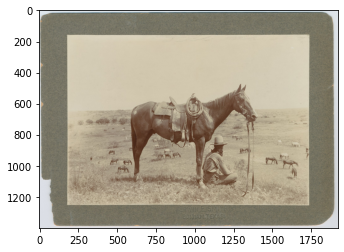

In [63]:
plt.imshow(image)

Sample text:

In [64]:
print(text)

O give me a home where the buffaloes roam
Where the deer and the antelope play
Where seldom is heard a discouraging word
And the skies are not cloudy all day
Home, home on the range
Where the deer and the antelope play
Where seldom is heard a discouraging word
And the skies are not cloudy all day
Where the air is so pure and the zephyrs so free
And the breezes so balmy and light
That I would not exchange my home on the range
For all of the cities so bright
Home, home on the range
Where the deer and the antelope play
Where seldom is heard a discouraging word
And the skies are not cloudy all day
How often at night when the heavens are bright
With the light of the glittering stars
I stand there amazed and I ask as I gaze
Does their glory exceed that of ours?
Home, home on the range
Where the deer and the antelope play
Where seldom is heard a discouraging word
And the skies are not cloudy all day


## Wrangling `DataFrame`s

Wrangling a well-formed DataFrame just returns itself:

In [65]:
wrangled_df = dw.wrangle(dataframe)
assert np.allclose(dataframe, wrangled_df)
wrangled_df

,FirstDim,SecondDim,ThirdDim,FourthDim,FifthDim
ByTwos,,,,,
0,1,2,3,4,5
2,2,4,6,8,10
4,3,6,9,12,15
5,4,8,12,16,20
6,5,10,15,20,25
8,6,12,18,24,30
10,7,14,21,28,35


## Wrangling `Array`s

Wrangling an Array turns it into a DataFrame.  If the Array is 2D, the resulting DataFrame will have the same
shape:

In [66]:
wrangled_array = dw.wrangle(array)
assert np.allclose(dataframe, wrangled_array)
wrangled_array

,0,1,2,3,4
0,1,2,3,4,5
1,2,4,6,8,10
2,3,6,9,12,15
3,4,8,12,16,20
4,5,10,15,20,25
5,6,12,18,24,30
6,7,14,21,28,35


Note that we've recovered the original DataFrame, but the index and column labels have been reset.  We can provide
these labels to the wrangle function.  The `array_kwargs` keyword argument specifies how array (or array-like) data
objects should be turned into DataFrames:

In [67]:
array_kwargs = {'index': dataframe.index, 'columns': dataframe.columns}
wrangled_array2 = dw.wrangle(array, array_kwargs=array_kwargs)
wrangled_array2

,FirstDim,SecondDim,ThirdDim,FourthDim,FifthDim
ByTwos,,,,,
0,1,2,3,4,5
2,2,4,6,8,10
4,3,6,9,12,15
5,4,8,12,16,20
6,5,10,15,20,25
8,6,12,18,24,30
10,7,14,21,28,35


## Wrangling text data using natural language processing models

Next, let's play with some text data.  By default, `data-wrangler` embeds text using a Latent Dirichlet Allocation model
trained on a curated version of Wikipedia, called the "minipedia" corpus.  First we'll split the text into its component
lines, and then we'll wrangle the result:

In [ ]:
lines = text.split('\n')  # creates a list of strings (one string per line)
wrangled_text = dw.wrangle(lines)
wrangled_text

In the resulting DataFrame, each row corresponds to a line of text, and each column corresponds to an embedding
dimension.  To get a better feel for what these dimensions mean, we can use the `return_model` flag to get back the
fitted model, and then we can examine the top-weighted words from each topic:

In [ ]:
wrangled_text2, text_model = dw.wrangle(lines, text_kwargs={'return_model': True})

In [ ]:
# display top words from the model
def get_top_words(model, n_words=10):
  vectorizer = model[0]['model']
  embedder = model[1]['model']

  vocab = {v: k for k, v in vectorizer.vocabulary_.items()}
  top_words = []
  for k in range(embedder.components_.shape[0]):
      top_words.append([vocab[i] for i in np.argsort(embedder.components_[k, :])[::-1][:n_words]])
  return top_words

def display_top_words(model, n_words=10):
  for k, w in enumerate(get_top_words(model, n_words=n_words)):
      print(f'Topic {k}: {", ".join(w)}')

print(f'Top words from each of the {wrangled_text2.shape[1]} discovered topics:\n')
display_top_words(text_model)

Then we can ask which topics had the most weight in each line:

In [ ]:
i = 1
line_embedding = wrangled_text2.loc[i].values
line_top_topic = np.where(line_embedding == np.max(line_embedding))[0][0]

print(f'Line {i} put the most weight on topic {line_top_topic}: {lines[i]}')

Note that each time the model is re-trained, the topic weights will change.  If all text data are wrangled in a single
pass, `data-wrangler` will automatically apply the same model to all text data.  However, if the data are wrangled in
multiple calls to `dw.wrangle`, the model fit during the first pass should be re-used in subsequent analyses:

In [ ]:
def topics_match(a, b):
    if np.allclose(a, b):
        print('Topic weights match!')
    else:
        print('Topic weights do NOT match!')

topics_match(wrangled_text, wrangled_text2)

We can re-apply the already-fitted model to "new" text:

In [ ]:
wrangled_text3 = dw.wrangle(lines, text_kwargs={'model': text_model})
topics_match(wrangled_text2, wrangled_text3)

In addition to training scikit-learn text embedding models and applying them to new text, `data-wrangler` also provides
wrappers for all models on [hugging-face](https://huggingface.co/transformers/pretrained_models.html).  For example,
the example text may be embedded using BERT as follows:

In [ ]:
bert = {'model': 'TransformerDocumentEmbeddings', 'args': ['bert-base-uncased'], 'kwargs': {}}
bert_embeddings = dw.wrangle(lines, text_kwargs={'model': bert})
bert_embeddings

## Wrangling images

Images (stored in any format supported by [matplotlib](https://matplotlib.org/)) are wrangled into `DataFrame`s by
slicing the image along axis 2 (i.e., the color dimension), horizontally concatenating the slices, and then
turning the result into a `DataFrame`:

In [ ]:
wrangled_image = dw.wrangle(image)
plt.imshow(wrangled_image);

## Objects, file paths, URLs, and Google IDs

Data supplied to `data-wrangler` may be passed in directly as a Python object that is already loaded into memory (as in
the above examples).  However, data may also be supplied as a (string) file path, URL, or Google ID.  For example,
wrangling the already loaded-in image versus wrangling the image's file path will yield the same result:

In [ ]:
wrangled_image_from_path = dw.wrangle(image_file)

def images_match(a, b):
    if np.allclose(a, b):
        print('The wrangled images match!')
    else:
        print('The wrangled images do NOT match!')

images_match(wrangled_image, wrangled_image_from_path)

Loading an image from a URL:

In [ ]:
image_url = 'https://raw.githubusercontent.com/ContextLab/data-wrangler/main/tests/resources/wrangler.jpg'
wrangled_image_from_url = dw.wrangle(image_url)
images_match(wrangled_image, wrangled_image_from_url)